In [1]:
using PorousMaterials # Pkg.clone("https://github.com/SimonEnsemble/PorousMaterials.jl", "v0.1.1")
using CSV
using DataFrames
using TSne
using PyCall
@pyimport adjustText
import PyPlot; const plt = PyPlot # now do plt.plt[:hist] for example
using DelimitedFiles
using LinearAlgebra
using Printf
using Random
using Optim
using ProgressMeter
using JLD2
using CoherentPointDrift # https://github.com/SimonEnsemble/CoherentPointDrift.jl
using LaTeXStrings

┌ Info: Recompiling stale cache file /home/sturlusa/.julia/compiled/v1.0/Optim/R5uoh.ji for Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1184


Cage database CDB41 (41 cages) from [here](https://github.com/marcinmiklitz/CDB41). Cleaned of solvent. Thanks to Kim Jelfs and M. Miklitz for kindly providing the cages.

Reference:
> M. Miklitz, S. Jiang, R. Clowes, M. E. Briggs, A. I. Cooper and K. E. Jelfs, Computational Screening of Porous Organic Molecules for Xenon/Krypton Separation, J. Phys. Chem. C, 2017. DOI: 10.1021/acs.jpcc.7b03848

Other set of 33 cages from the .xyz files deposited as ESI of DOI 10.1038/s41467-018-05271-9

> R. L. Greenaway, V. Santolini, M. J. Bennison, B. M. Alston, C. J. Pugh, M. A. Little, M. Miklitz, E. G. B. Eden-Rump, R. Clowes, A. Shakil, H. J. Cuthbertson, H. Armstrong, M. E. Briggs, K. E. Jelfs & A. I. Cooper. High-throughput discovery of organic cages and catenanes using computational screening fused with robotic synthesis. Nature Communications, 2018. DOI: 10.1038/s41467-018-05271-9
                                                              
I manually looked at Fig 4 in the main text and selected those that were synthesized. Some cages required visualization to compare to Fig 4 since e.g. there are multiple versions of B23, a few of which were apparently not synthesized but only computational predictions.

The `.xyz` files describing the molecular structure of all of these cages are in the directory `all_cages`.

In [2]:
cages = readdlm("all_cages/all_cages.txt")
cages[1]

"A11"

In [3]:
aligned_and_centered_cage(cage::AbstractString) = read_xyz("all_cages/" * cage * "_final_alignment.xyz")
final_aligned_and_centered_cage(cage::AbstractString) = read_xyz("final_aligned_cages/" * cage * ".xyz")

final_aligned_and_centered_cage (generic function with 1 method)

## Generate 3D void space images
Superimpose a regular 3D grid of points centered at the cage center of mass. 
Compute the potential energy of a Helium probe at each grid point.
If the energy is less than a certain value, that point is declared "accessible".
Think of this as a CAT scan for cages!

Set up computation of potential energy of Helium probe in the cages

In [4]:
he = Molecule("He")

cutoffradius = 14.0 # vdw cutoff radius
ljff = LJForceField("UFF.csv", cutoffradius=cutoffradius, mixing_rules="geometric");

Write padded .cif files of the cages for molecular simulations. 
In the same loop, determine what size of snapshot we need to encapsulate all cages.

In [5]:
snapshot_dim = 0.0 # find max dimension we need for snapshot to include all atoms of all cages
biggest_cage = ""

for cage in cages
    # read in aligned and centered cage
    atoms, x = final_aligned_and_centered_cage(cage)
    # observe max dimension so we know size of snapshot to take.
    x_span = 2.0 * maximum(abs.(x))
    if x_span > snapshot_dim # 2 b/c centered at zero
        snapshot_dim = x_span
        biggest_cage = cage
    end
    
    #
    # write to .cif for molecular simulation
    #
    # make sure with PBCs no interactions are included by padding
    box = Box([x_span + 2 * cutoffradius for blah = 1:3]..., 
              [π/2 for blah = 1:3]...)
    # when writing .cif, shift coords so they are in [0, 1]^3
    #    so in .cif center of mass is center of box.
    x_shift = [x_span + 2 * cutoffradius for blah = 1:3] / 2.0
    framework = Framework(cage, box, 
                          Atoms(atoms, x), 
                          Charges(Array{Float64, 1}(undef, 0), Array{Float64, 2}(undef, 0, 0))
                          )
    write_cif(framework, 
        @sprintf("data/crystals/%s_aligned.cif", cage))
end

println("aligned and centered cages written to .xyz in all_cages/*_aligned.xyz")
println("see data/crystals for .cif's padded by cutoffradius for molecular simulations'")
println("Largest cage: :", biggest_cage)

aligned and centered cages written to .xyz in all_cages/*_aligned.xyz
see data/crystals for .cif's padded by cutoffradius for molecular simulations'
Largest cage: :MC6


In [6]:
snapshot_dim = ceil(snapshot_dim)
println("Dimension of snapshot to fit all porous cages (Å): ", snapshot_dim)

const center_of_box = [snapshot_dim / 2.0 for d = 1:3]

const snapshot_box = Box(snapshot_dim, snapshot_dim, snapshot_dim, π/2, π/2, π/2)

Dimension of snapshot to fit all porous cages (Å): 38.0


Bravais unit cell of a crystal.
	Unit cell angles α = 90.000000 deg. β = 90.000000 deg. γ = 90.000000 deg.
	Unit cell dimensions a = 38.000000 Å. b = 38.000000 Å, c = 38.000000 Å
	Volume of unit cell: 54872.000000 Å³


Discretize space; `x_grid_pts` ranges from `-snapshot_dim` to `snapshot_dim` so it overlays the cage coordinates.

In [7]:
const nb_grid_pts = 50
const x_grid_pts = collect(range(0, stop=snapshot_dim, length=nb_grid_pts)) .- snapshot_dim / 2.0

50-element Array{Float64,1}:
 -19.0              
 -18.224489795918366
 -17.448979591836736
 -16.6734693877551  
 -15.89795918367347 
 -15.122448979591837
 -14.346938775510203
 -13.571428571428571
 -12.795918367346939
 -12.020408163265305
 -11.244897959183675
 -10.46938775510204 
  -9.693877551020408
   ⋮                
  10.46938775510204 
  11.244897959183675
  12.020408163265305
  12.795918367346939
  13.57142857142857 
  14.346938775510203
  15.122448979591837
  15.897959183673471
  16.673469387755105
  17.448979591836732
  18.224489795918366
  19.0              

Build data matrix `A`, whose rows are the flattened snapshots of a particular cage.

In [8]:
A = zeros(Float64, length(cages), nb_grid_pts ^ 3)

for (c, cage) in enumerate(cages)
    # read in aligned and centered cage
    atoms, x = final_aligned_and_centered_cage(cage)
    
    # assert snapshot box is big enough
    @assert(all(x .< maximum(x_grid_pts)) && all(x .> minimum(x_grid_pts)),
        "atoms outside snapshot!")
    
    # convert cage to a list of LJSphere's for PorousMaterials.jl
    ljspheres = Atoms(atoms, x)
    
    # preallocate grid; choose origin here solely for visualization
    # when we write to a .cube file. the origin passed to `Grid`
    # is so the cage is centered at the origin in the viz. (checked)
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                zeros(Float64, nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                :accessibility, -center_of_box)
        
    for i = 1:nb_grid_pts, j = 1:nb_grid_pts, k = 1:nb_grid_pts
        # what grid pt is here inside the loop?
        x_grid_pt = [x_grid_pts[i], x_grid_pts[j], x_grid_pts[k]]
        
        # put helium at this grid pt
        translate_to!(he, x_grid_pt)
        
        # compute potential energy of He adsorbate here
        energy = vdw_energy_no_PBC(he, ljspheres, ljff)
        
        # if framework atom overlaps with cage atom... energy > k T
        if energy > 298.0
            grid.data[i, j, k] = 1.0
        end
    end
    
    # save grid for visualization
    write_cube(grid, cages[c] * ".cube", verbose=false)
    
    # add flattened grid as a row of the matrix `A`
    A[c, :] = grid.data[:]
    
    # assert that we can recover the snapshot by reshaping the rows of A
    @assert(isapprox(
            reshape(A[c, :], (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
            grid.data)
           )
end

println("see data/grids for .cube visualizations of the cage scans")
size(A)

see data/grids for .cube visualizations of the cage scans


(74, 125000)

Compute the average cage.

In [9]:
average_cage = zeros(Float64, nb_grid_pts ^ 3)
for c = 1:length(cages)
    average_cage += A[c, :]
end
average_cage /= length(cages)

# write to .cube
grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
            reshape(average_cage, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
            :accessibility, -center_of_box)

write_cube(grid, "average_cage.cube")
@printf("%d/%d pixels nonzero in average cage\n", sum(average_cage .!= 0), length(average_cage))

	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/average_cage.cube
48334/125000 pixels nonzero in average cage


Subtract off the average cage from each cage.

In [10]:
for c = 1:length(cages)
    A[c, :] = A[c, :] - average_cage
end

At this point, if $\mathbf{x_i}$ is a feature vector (a row of `A`), then $\sum_i \mathbf{x_i} = \mathbf{0}$. See [here](https://epubs.siam.org/doi/pdf/10.1137/S0036144501387517).

In [11]:
x_sum = zeros(nb_grid_pts ^ 3)
for c = 1:length(cages)
    x_sum += A[c, :]
end
@assert(all(isapprox.(x_sum, zeros(nb_grid_pts ^ 3), atol=1e-5)))

Perform the SVD decomposition of the data matrix

In [12]:
UΣVᵀ = svd(A)

println("size of U: ", size(UΣVᵀ.U))
println("# singular values: ", length(UΣVᵀ.S))
println("size of Vᵀ: ", size(UΣVᵀ.Vt))

@assert(isapprox(A, UΣVᵀ.U * diagm(0 => UΣVᵀ.S) * UΣVᵀ.Vt))

size of U: (74, 74)
# singular values: 74
size of Vᵀ: (74, 125000)


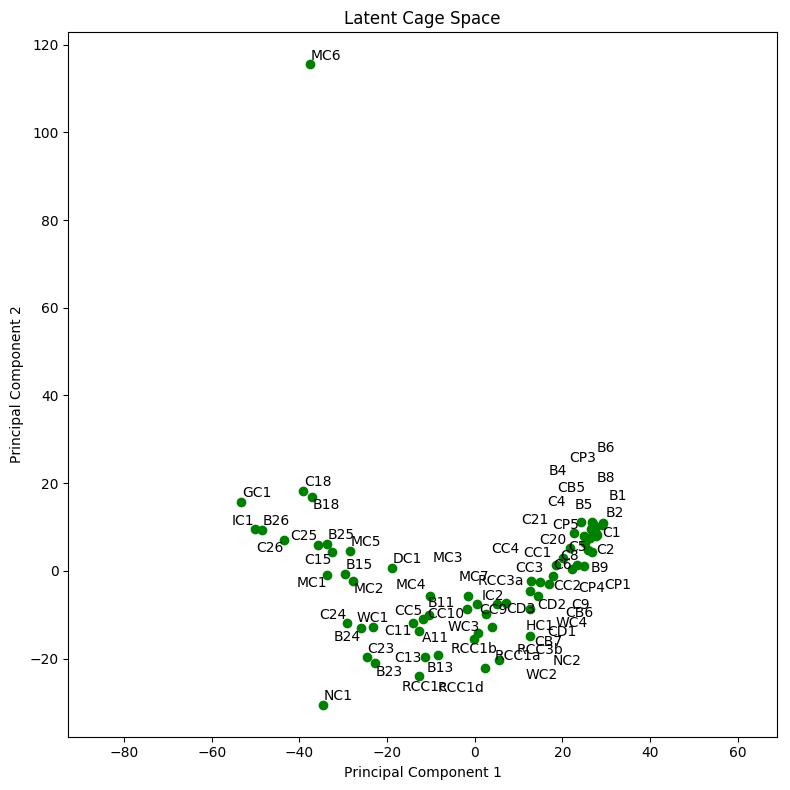

In [13]:
x_pca = UΣVᵀ.U[:,1:2] * diagm(0 => UΣVᵀ.S[1:2])

fig = plt.figure(figsize=(8,8))
plt.scatter(x_pca[:, 1], x_pca[:, 2], color="g")

texts = []
for i = 1:length(cages)
    push!(texts,
        plt.annotate(cages[i], (x_pca[i, 1], x_pca[i, 2]))
    )
end
adjustText.adjust_text(texts)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.axis("equal")
plt.title("Latent Cage Space")
plt.tight_layout()
plt.savefig("PCA_latent_cage_space_2D.pdf", format="pdf", dpi=300)
plt.show()

Lets see where the flexible CC2, CC3 and CC4 cages get mapped to in this latent space

In [26]:
flexible_cages_cc2 = [cage for (i, cage) in enumerate(readdlm("all_cages/flexible_cages/flexible_cc2_files.txt")) if (i%5==0)]
flexible_cages_cc3 = [cage for (i, cage) in enumerate(readdlm("all_cages/flexible_cages/flexible_cc3_files.txt")) if (i%5==0)]
flexible_cages_cc4 = [cage for (i, cage) in enumerate(readdlm("all_cages/flexible_cages/flexible_cc4_files.txt")) if (i%5==0)]
flexible_cages_cc5 = [cage for (i, cage) in enumerate(readdlm("all_cages/flexible_cages/flexible_cc5_files.txt")) if (i%5==0)]
flexible_cages = [flexible_cages_cc2..., flexible_cages_cc3..., flexible_cages_cc4..., flexible_cages_cc5...]

320-element Array{SubString{String},1}:
 "all_cages/flexible_cages/CC2_xyz/cc2_104.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_109.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_113.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_118.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_122.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_127.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_131.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_136.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_140.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_145.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_14.xyz" 
 "all_cages/flexible_cages/CC2_xyz/cc2_154.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_159.xyz"
 ⋮                                             
 "all_cages/flexible_cages/CC5_xyz/cc5_4.xyz"  
 "all_cages/flexible_cages/CC5_xyz/cc5_54.xyz" 
 "all_cages/flexible_cages/CC5_xyz/cc5_59.xyz" 
 "all_cages/flexible_cages/CC5_xyz/cc5_63.xyz" 
 "all_cages/flexible_cages/CC5_xyz/cc5_68.xyz" 
 "all_cages/flexible_cages/CC5_xyz/cc5_72.xyz" 


In [27]:
A_flexible = zeros(Float64, length(flexible_cages), nb_grid_pts ^ 3)

for (c, cage) in enumerate(flexible_cages)

    # read in aligned and centered cage
    atoms, x = read_xyz(cage)
    
    # assert snapshot box is big enough
    @assert(all(x .< maximum(x_grid_pts)) && all(x .> minimum(x_grid_pts)),
        "atoms outside snapshot!")
    
    # convert cage to a list of LJSphere's for PorousMaterials.jl
    ljspheres = Atoms(atoms, x)
    
    # preallocate grid; choose origin here solely for visualization
    # when we write to a .cube file. the origin passed to `Grid`
    # is so the cage is centered at the origin in the viz. (checked)
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                zeros(Float64, nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                :accessibility, -center_of_box)
        
    for i = 1:nb_grid_pts, j = 1:nb_grid_pts, k = 1:nb_grid_pts
        # what grid pt is here inside the loop?
        x_grid_pt = [x_grid_pts[i], x_grid_pts[j], x_grid_pts[k]]
        
        # put helium at this grid pt
        translate_to!(he, x_grid_pt)
        
        # compute potential energy of He adsorbate here
        energy = vdw_energy_no_PBC(he, ljspheres, ljff)
        
        # if framework atom overlaps with cage atom... energy > k T
        if energy > 298.0
            grid.data[i, j, k] = 1.0
        end
    end
    
    # save grid for visualization
    # write_cube(grid, cages[c] * ".cube", verbose=false)
    
    # add flattened grid as a row of the matrix `A`
    A_flexible[c, :] = grid.data[:]
    
    # assert that we can recover the snapshot by reshaping the rows of A
    @assert(isapprox(
            reshape(A_flexible[c, :], (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
            grid.data)
           )
end

size(A)

(74, 125000)

In [28]:
for c = 1:length(flexible_cages)
    A_flexible[c, :] = A_flexible[c, :] - average_cage
end

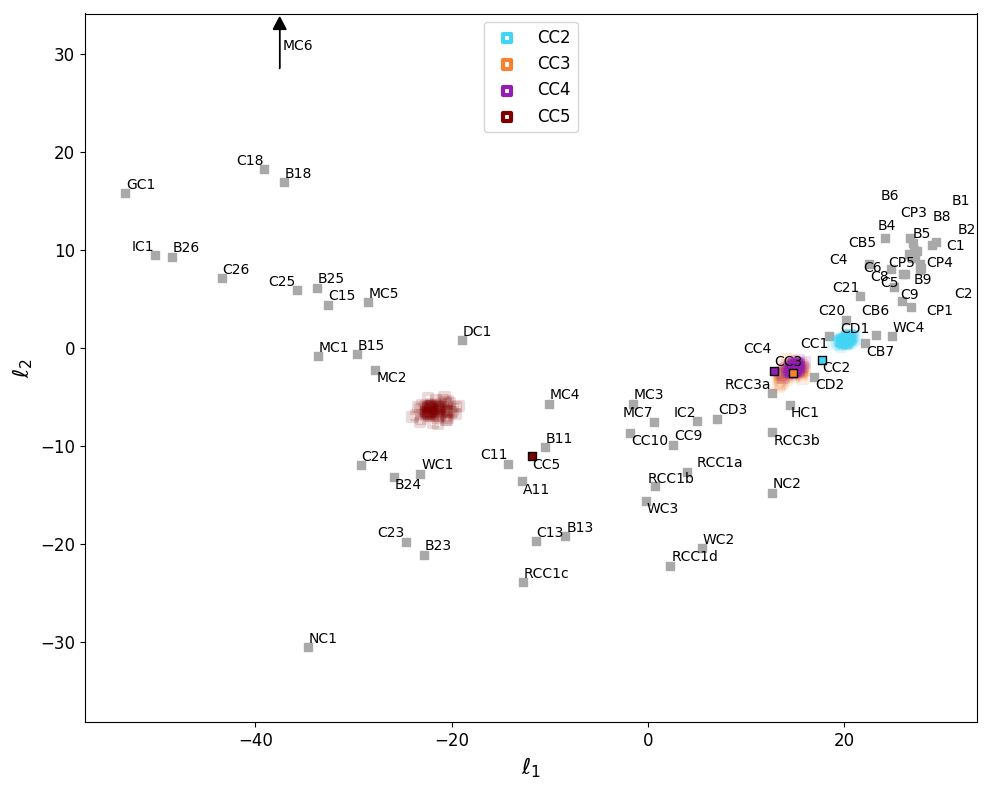

In [66]:
#x_pca = UΣVᵀ.U[:,1:2] * diagm(0 => UΣVᵀ.S[1:2])
flexible_x_pca = A_flexible * UΣVᵀ.V[:,1:2]
idx_mc6 = findfirst(cages .== "MC6")
idx_cc2 = findfirst(cages .== "CC2")
idx_cc3 = findfirst(cages .== "CC3")
idx_cc4 = findfirst(cages .== "CC4")
idx_cc5 = findfirst(cages .== "CC5")
augmented_cages = [cage for cage in cages if !any(x -> x == cage, ["CC2", "CC3", "CC4", "CC5"])]
augmented_index = [any(x -> x == cage, augmented_cages) for cage in cages]

fig = plt.figure(figsize=(10,8))
plt.scatter(x_pca[augmented_index[:], 1], x_pca[augmented_index[:], 2], color="#a9a9a9", marker="s")
plt.scatter(flexible_x_pca[1:80,1], flexible_x_pca[1:80,2], color="#42d4f4", facecolor="none", alpha=0.15, linewidths=3, label="CC2", marker="s") #Cyan
plt.scatter(flexible_x_pca[81:160, 1], flexible_x_pca[81:160, 2], color="#f58231", facecolor="none", alpha=0.15, linewidths=3, label="CC3", marker="s") #Orange
plt.scatter(flexible_x_pca[161:240, 1], flexible_x_pca[161:240, 2], color="#911eb4", facecolor="none", alpha=0.15, linewidths=3, label="CC4", marker="s") #Purple
plt.scatter(flexible_x_pca[241:320, 1], flexible_x_pca[241:320, 2], color="#800000", facecolor="none", alpha=0.15, linewidths=3, label="CC5", marker="s") #Maroon
plt.scatter(x_pca[idx_cc2[1], 1], x_pca[idx_cc2[1], 2], color="#42d4f4", edgecolors="k", marker="s")
plt.scatter(x_pca[idx_cc3[1], 1], x_pca[idx_cc3[1], 2], color="#f58231", edgecolors="k", marker="s")
plt.scatter(x_pca[idx_cc4[1], 1], x_pca[idx_cc4[1], 2], color="#911eb4", edgecolors="k", marker="s")
plt.scatter(x_pca[idx_cc5[1], 1], x_pca[idx_cc5[1], 2], color="#800000", edgecolors="k", marker="s")

texts = []
for i = 1:length(cages)
    if cages[i] == "MC6"
        push!(texts,
            plt.annotate(cages[i], (x_pca[i, 1]+0.25, 30.0))
        )
    else
        push!(texts,
            plt.annotate(cages[i], (x_pca[i, 1], x_pca[i, 2]))
        )
    end
end
ymax = 8
plt.arrow(x_pca[idx_mc6[1], 1], 28.5, 0, 4, head_width=1.3, head_length=1.25, fc="k", ec="k")
#plt.xlim(-20, 11)
#plt.ylim(-12, ymax)
leg = plt.legend(loc=9, fontsize=12)
for lh in leg[:legendHandles]
    lh[:set_alpha](1.0)
end

plt.xlabel(L"$\ell_1$", fontsize=16)
plt.ylabel(L"$\ell_2$", fontsize=16)
plt.axis("equal")
plt.ylim(-12, ymax)
ax = plt.axes()
ax[:tick_params]("both",labelsize=12)
plt.tight_layout()
adjustText.adjust_text(texts)

plt.savefig("PCA_latent_cage_space_with_flexible_cages_2D_SI_ell.pdf", format="pdf", dpi=300)
plt.show()